# Regions Visualization 2D example

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

In [9]:
# Configuration
dataset_dir = Path("../dataset/2D_OW/CASE_2D.sim.dataset/XMGN_2D_Q5SP_Waterflood")
case_name = "CASE_2D_10"
timestep = 2

In [10]:
# Load partition assignments
partition_json = dataset_dir / f"{case_name}_partitions.json"
with open(partition_json, 'r') as f:
    partition_info = json.load(f)

# Load raw graph
graph_file = dataset_dir / "graphs" / f"{case_name}_{timestep:03d}.pt"
graph = torch.load(graph_file, weights_only=False)

# Load partitioned graph (check train/val/test)
for split in ['train', 'val', 'test']:
    partitions_file = dataset_dir / "partitions" / split / f"partitions_{case_name}_{timestep:03d}.pt"
    if partitions_file.exists():
        break

partitions = torch.load(partitions_file, weights_only=False)

print(f"✓ Loaded data for {case_name}, timestep {timestep}")
print(f"  - Number of partitions: {len(partitions)}")
print(f"  - Total nodes: {graph.num_nodes}")

✓ Loaded data for CASE_2D_10, timestep 2
  - Number of partitions: 2
  - Total nodes: 441


In [11]:
# Extract Coordinates and Partition Info
# Get coordinates
if hasattr(graph, 'coordinates'):
    coords = graph.coordinates.numpy()
else:
    coords = graph.x[:, 2:5].numpy()  # X, Y, Z from node features

X, Y = coords[:, 0], coords[:, 1]

# Partition assignments (1-indexed)
partition_assignment = np.array(partition_info['partition_assignment'])
num_partitions = partition_info['num_partitions']

print(f"Grid dimensions: {graph.grid_info['nx']} × {graph.grid_info['ny']}")


Grid dimensions: 21 × 21


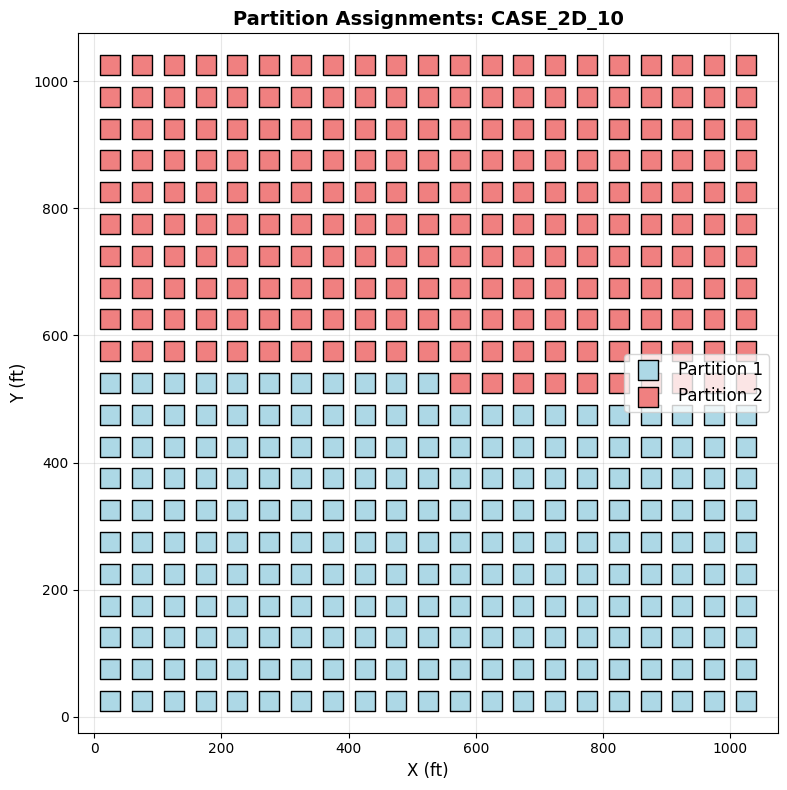

In [12]:
# Visualize Partition Assignments

fig, ax = plt.subplots(figsize=(8, 8))

colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow'][:num_partitions]

for part_id in range(1, num_partitions + 1):
    mask = partition_assignment == part_id
    ax.scatter(X[mask], Y[mask], c=colors[part_id-1], 
              s=200, edgecolors='black', linewidths=1,
              label=f'Partition {part_id}', marker='s')

ax.set_title(f'Partition Assignments: {case_name}', fontsize=14, fontweight='bold')
ax.set_xlabel('X (ft)', fontsize=12)
ax.set_ylabel('Y (ft)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


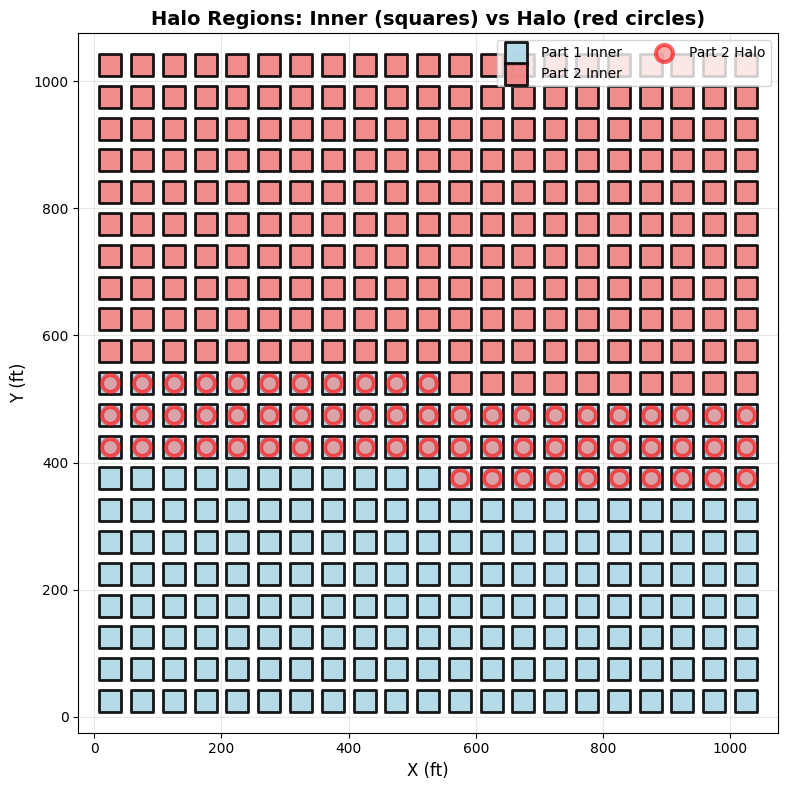

In [13]:
# Identify and visualize halo regions

# Create halo mask
halo_info = {}
for part_idx, partition in enumerate(partitions):
    part_nodes = partition.part_node.numpy()
    inner_nodes_local = partition.inner_node.numpy()
    inner_nodes_global = part_nodes[inner_nodes_local]
    
    # Find halo nodes
    halo_mask_local = np.ones(len(part_nodes), dtype=bool)
    halo_mask_local[inner_nodes_local] = False
    halo_nodes_global = part_nodes[halo_mask_local]
    
    halo_info[part_idx + 1] = {
        'inner': inner_nodes_global,
        'halo': halo_nodes_global,
        'all': part_nodes
    }

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))

# Plot inner nodes (squares)
for part_id in range(1, num_partitions + 1):
    inner_nodes = halo_info[part_id]['inner']
    ax.scatter(X[inner_nodes], Y[inner_nodes], 
              c=colors[part_id-1], s=250, marker='s',
              edgecolors='black', linewidths=2,
              label=f'Part {part_id} Inner', alpha=0.9)

# Plot halo nodes (circles with red border)
for part_id in range(1, num_partitions + 1):
    halo_nodes = halo_info[part_id]['halo']
    if len(halo_nodes) > 0:
        ax.scatter(X[halo_nodes], Y[halo_nodes],
                  c=colors[part_id-1], s=150, marker='o',
                  edgecolors='red', linewidths=3,
                  label=f'Part {part_id} Halo', alpha=0.6)

ax.set_title('Halo Regions: Inner (squares) vs Halo (red circles)', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('X (ft)', fontsize=12)
ax.set_ylabel('Y (ft)', fontsize=12)
ax.legend(fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [14]:
print(f"\n{'='*60}")
print(f"Partition Statistics: {case_name}")
print(f"{'='*60}")
print(f"Grid: {graph.grid_info['nx']} × {graph.grid_info['ny']} cells")
print(f"Active cells: {len(partition_assignment)}")
print(f"Partitions: {num_partitions}")
print(f"\nDetailed Breakdown:")

for part_idx, partition in enumerate(partitions):
    part_id = part_idx + 1
    num_inner = len(halo_info[part_id]['inner'])
    num_halo = len(halo_info[part_id]['halo'])
    num_total = partition.num_nodes
    
    print(f"\n  Partition {part_id}:")
    print(f"    Inner nodes:  {num_inner:4d}")
    print(f"    Halo nodes:   {num_halo:4d}")
    print(f"    Total nodes:  {num_total:4d}")
    print(f"    Halo ratio:   {num_halo/num_total:6.1%}")

print(f"\n{'='*60}")



Partition Statistics: CASE_2D_10
Grid: 21 × 21 cells
Active cells: 441
Partitions: 2

Detailed Breakdown:

  Partition 1:
    Inner nodes:   221
    Halo nodes:      0
    Total nodes:   221
    Halo ratio:     0.0%

  Partition 2:
    Inner nodes:   220
    Halo nodes:     63
    Total nodes:   283
    Halo ratio:    22.3%

